### Optional Research Challenge

Given: are two image stacks, each stored in a .tif file, and each having 300 layers (individual images)

You can view these stacks, for example, in ImageJ (drag&drop): https://imagej.net/ij/ , or simply implement a python script that loads and display them (you can use ChatGPT & co.
to generate one).

Both images stacks encode focus / defocus of a scenery (plants). Focus changes from top (first layer in the stacks) to bottom (last layers in the stacks). See example layers in the following slides. 

It appears, that out-of-focus regions always have a similar noise pattern (i.e. the standard deviation in such regions is similar) while in-focus regions have very different noise patterns (either extremely high at edge boundaries, or extreme low at surfaces) with corresponding standard deviations.

**Task**: Can you distinguish (segment) between out-of-focus (with common noise pattern for out-of-focus regions) and in-focus (with noise patterns that are very different from the
out-of-focus patterns) regions?

**Hint**: Models, such as computing and comparing std. deviation, lead to noisy results. They are too simple to describe the noise statistics. Approach an ML-solution that learns how
to describe the noise statistics better (e.g., via more than one (learned) operations, such as kernels in multiple conv. layers – as std. deviation is only one modeled (not learned)
operation).

**Hint 2**: The noise statistics of out-of-focus and in-focus regions are “similar” within the same stack. They might be slightly different in other stacks.

**Submission**: Submit only (OK) working solutions (no solutions that don’t work at all or deliver bad results). You need to submit your code, the segmented results (images), and a
short description (you chose the format and length) on how you solved the problem. Any help (including LLMs) is allowed. Deadline: 10.12.2024, 12 noon, to oliver.bimber@jku.at
(3 weeks).

**General**: At max. you can gain 25% of your lab points (which is equivalent to one full assignment) in addition. These points can be used to compensate for missing assignment
points (to improve your grade), or to skip any upcoming assignments (and compensate for it with the points of the research challenge). Note, that points of the research challenge
are on top the points of the regular assignments. Thus, the research challenge is optional, and all students doing only the regular assignments have a change to achieve 100% of
their lab grade with them only. This research challenge is intended for motivated students that are underchallenged with the regular assignments and are interested in solving more
research oriented tasks. You can approach this research challenge alone or as team of two (each getting the same points).

### Analysis

I combined multiple image stacks to create a unified dataset, from which I sampled patches to train a self-supervised model. I employed an encoder-decoder structure to extract meaningful representations of the image content. The encoder learns to compress the image patches into a latent space, capturing essential features, while the decoder attempts to reconstruct the original patches from these latent codes.

By training the model to minimize the reconstruction error, I encouraged the encoder-decoder pair to learn a latent representation that faithfully describes the underlying structure of the images. Once the model was trained, I used the reconstruction error as an indicator of how well the learned features represent a particular region. Areas that the model could reconstruct accurately showed low error, suggesting they were well-represented by the learned features. Conversely, regions with higher reconstruction error indicated that those areas differed significantly from what the model had learned, possibly signaling different properties such as being out of focus.

Leveraging this reconstruction error, I performed segmentation by thresholding the error values. Pixels or patches with low error were classified as one category (e.g., “in-focus”), while those with high error were assigned to another category (e.g., “out-of-focus”). This allowed me to obtain a binary segmentation map that effectively separated distinct regions based on the model’s learned features and their corresponding reconstruction quality.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  #
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

class MultiStackPatchDataset(Dataset):
    def __init__(self, stack_paths, patch_size=64, num_patches=5000, use_layer='mean'):
       
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.imgs = []
        for sp in stack_paths:
            stack = tifffile.imread(sp)
            num_layers, H, W = stack.shape
            if use_layer == 'mean':
                img = stack.mean(axis=0).astype(np.float32)
            elif use_layer == 'middle':
                l = num_layers // 2
                img = stack[l].astype(np.float32)
            else:
                l = int(use_layer)
                img = stack[l].astype(np.float32)

            max_val = img.max() if img.max()>0 else 1.0
            img /= max_val
            self.imgs.append(img)
        
        patches_per_image = self.num_patches // len(self.imgs)
        
        self.coords = []
        self.img_indices = []
        
        for img_idx, img in enumerate(self.imgs):
            H, W = img.shape
            for _ in range(patches_per_image):
                y = np.random.randint(0, H - patch_size)
                x = np.random.randint(0, W - patch_size)
                self.coords.append((y,x))
                self.img_indices.append(img_idx)

        while len(self.coords) < self.num_patches:
            img_idx = np.random.randint(0, len(self.imgs))
            img = self.imgs[img_idx]
            H, W = img.shape
            y = np.random.randint(0, H - patch_size)
            x = np.random.randint(0, W - patch_size)
            self.coords.append((y,x))
            self.img_indices.append(img_idx)

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img_idx = self.img_indices[idx]
        img = self.imgs[img_idx]
        y,x = self.coords[idx]
        patch = img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x), img_idx

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        # Normalization
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_paths = ["stacks/stack1.tif", "stacks/stack2.tif"]
patch_size = 64
num_patches = 50000

dataset = MultiStackPatchDataset(stack_paths, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 1000
loss_history = []

best_loss = float('inf')
patience = 101  
no_improvement_count = 0

best_save = f"Combined_best_model_SimCLR_{patch_size}.pth"

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for (view1, view2, _, _) in dataloader:
        view1 = view1.to(device)
        view2 = view2.to(device)
        optimizer.zero_grad()
        loss = model(view1, view2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement_count = 0
        print('Model Saved')
        torch.save(model.state_dict(), best_save)
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

# Save the loss history as a numpy file for future reference
np.save("loss_history.npy", np.array(loss_history))

plt.figure()
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png", dpi=300)
plt.close()


Using device: mps
Epoch [1/1000] Loss: 4.1289
Model Saved
Epoch [2/1000] Loss: 3.2936
Model Saved
Epoch [3/1000] Loss: 2.2509
Model Saved
Epoch [4/1000] Loss: 1.9537
Model Saved
Epoch [5/1000] Loss: 1.7219
Model Saved
Epoch [6/1000] Loss: 1.5372
Model Saved
Epoch [7/1000] Loss: 1.3679
Model Saved
Epoch [8/1000] Loss: 1.2034
Model Saved
Epoch [9/1000] Loss: 1.0858
Model Saved
Epoch [10/1000] Loss: 1.0141
Model Saved
Epoch [11/1000] Loss: 0.9515
Model Saved
Epoch [12/1000] Loss: 0.8839
Model Saved
Epoch [13/1000] Loss: 0.8348
Model Saved
Epoch [14/1000] Loss: 0.7891
Model Saved
Epoch [15/1000] Loss: 0.7469
Model Saved
Epoch [16/1000] Loss: 0.7060
Model Saved
Epoch [17/1000] Loss: 0.6904
Model Saved
Epoch [18/1000] Loss: 0.6362
Model Saved
Epoch [19/1000] Loss: 0.6039
Model Saved
Epoch [20/1000] Loss: 0.5719
Model Saved
Epoch [21/1000] Loss: 0.5533
Model Saved
Epoch [22/1000] Loss: 0.5225
Model Saved
Epoch [23/1000] Loss: 0.5000
Model Saved
Epoch [24/1000] Loss: 0.4804
Model Saved
Epoch [

### Visualization Notebook (Optional)

Using device: mps


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_1774/1400879483.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_save))

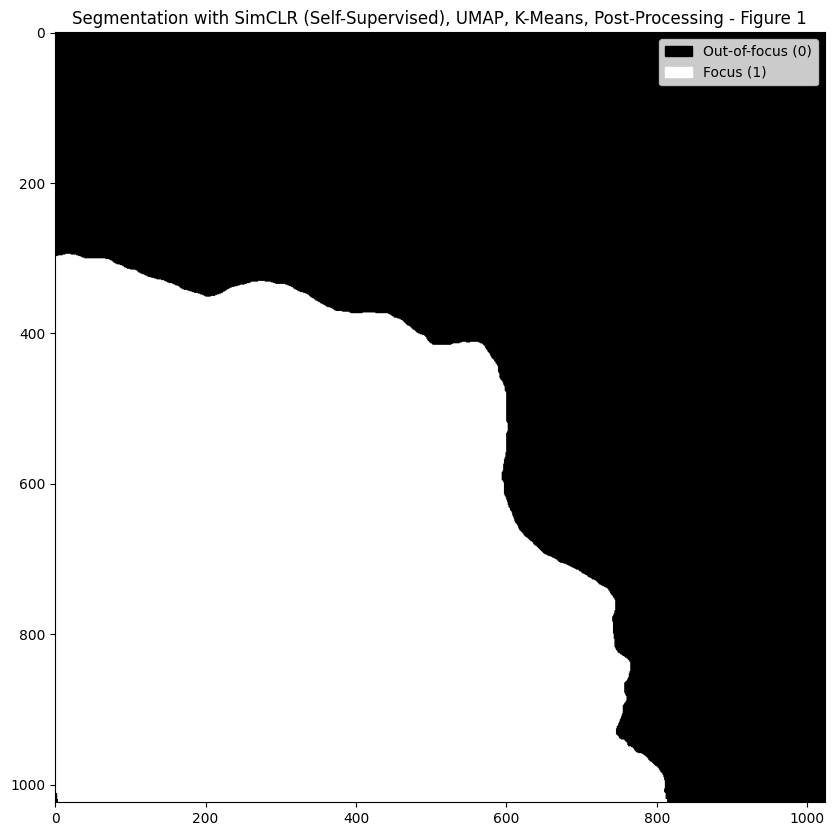

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches

class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_path = "stacks/stack1.tif"
patch_size = 64
num_patches = 50000

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)

best_save = f"Combined_best_model_SimCLR_{patch_size}.pth"

model.load_state_dict(torch.load(best_save))
model.eval()

dataset_for_cluster = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader_for_cluster = DataLoader(dataset_for_cluster, batch_size=64, shuffle=False)

features = []
coords = dataset_for_cluster.coords
with torch.no_grad():
    for (view1, view2, c) in dataloader_for_cluster:
        view1 = view1.to(device)
        z = model.encoder(view1)
        z = z.cpu().numpy()
        features.append(z)
features = np.concatenate(features, axis=0)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = reducer.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(umap_features)

H, W = dataset_for_cluster.H, dataset_for_cluster.W
prob_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

for i, (y,x) in enumerate(coords):
    val = float(labels[i])
    prob_map[y:y+patch_size, x:x+patch_size] += val
    count_map[y:y+patch_size, x:x+patch_size] += 1.0

mask = np.zeros((H,W), dtype=np.float32)
valid = (count_map>0)
mask[valid] = prob_map[valid]/count_map[valid]
binary_map = (mask>0.5).astype(np.uint8)

binary_map = median_filter(binary_map, size=5)
binary_map = opening(binary_map, square(5))
binary_map = closing(binary_map, square(5))

plt.figure(figsize=(10,10))
plt.imshow(binary_map, cmap='gray')
plt.title("Segmentation with SimCLR (Self-Supervised), UMAP, K-Means, Post-Processing - Figure 1")

non_a_fuoco_patch = mpatches.Patch(color='black', label='Out-of-focus (0)')
a_fuoco_patch = mpatches.Patch(color='white', label='Focus (1)')

plt.legend(handles=[non_a_fuoco_patch, a_fuoco_patch], loc='upper right')
plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

patch_size = 64
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
best_save = f"Combined_best_model_SimCLR_{patch_size}.pth"

######################
# Modello Encoder (SimCLR Encoder)
######################
class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1), # 1->16, 64x64->32x32
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1), # 16->32,32x32->16x16
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), # 32->64,16x16->8x8
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        return z1, z2

######################
# Carica modello SimCLR e estrai encoder
######################
encoder_model = SmallEncoder(out_dim=128)
model_simclr = SimCLR(encoder_model)
model_simclr.load_state_dict(torch.load(best_save, map_location=device))
model_simclr.to(device)
model_simclr.eval()

# Estrai l'encoder e congela i pesi
for param in model_simclr.encoder.parameters():
    param.requires_grad = False

encoder = model_simclr.encoder

######################
# Definizione Decoder
######################
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.fc_decode = nn.Linear(latent_dim, 64*1*1) # ricostruiamo un "codice" 64 canali 1x1
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,2,1),  # 64->32, 1x1->2x2
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,2,1),  # 32->16,2x2->4x4
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,4,2,1),   # 16->8,4x4->8x8
            nn.ReLU(),
            nn.ConvTranspose2d(8,4,4,2,1),    # 8->4,8x8->16x16
            nn.ReLU(),
            nn.ConvTranspose2d(4,2,4,2,1),    # 4->2,16x16->32x32
            nn.ReLU(),
            nn.ConvTranspose2d(2,1,4,2,1),    # 2->1,32x32->64x64
            nn.Sigmoid()  # output tra [0,1]
        )

    def forward(self, z):
        h = self.fc_decode(z) # (B,64)
        h = h.view(h.size(0),64,1,1)
        recon = self.decoder_conv(h)
        return recon

decoder = Decoder(latent_dim=128).to(device)

######################
# Dataset per addestrare il decoder
######################
class ReconstructionDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=10000):
        stack = tifffile.imread(stack_path) # (num_layers,H,W)
        img = stack.mean(axis=0).astype(np.float32)
        max_val = img.max() if img.max()>0 else 1.0
        img /= max_val
        H, W = img.shape
        self.patch_size = patch_size
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, H - patch_size)
            x = np.random.randint(0, W - patch_size)
            self.coords.append((y,x))
        self.img = img
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_tensor = self.transform(patch) # (1,64,64)
        return patch_tensor

train_dataset = ReconstructionDataset("stacks/stack1.tif", patch_size=patch_size, num_patches=50000)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

######################
# Addestramento del decoder con scheduler ed early stopping
######################
optimizer_dec = optim.Adam(decoder.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer_dec, step_size=10, gamma=0.5)
mse_loss = nn.MSELoss()

epochs = 1000
best_loss = float('inf')
patience = 20
no_improvement_count = 0
loss_history = []

for epoch in range(epochs):
    decoder.train()
    running_loss = 0.0
    for patch_tensor in train_loader:
        patch_tensor = patch_tensor.to(device)
        with torch.no_grad():
            z = encoder(patch_tensor) # (B,128)
        # Ricostruzione
        recon = decoder(z)
        loss = mse_loss(recon, patch_tensor)
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_dec.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    scheduler.step()

    # Early Stopping
    if avg_loss < best_loss and avg_loss < 0.0088:
        best_loss = avg_loss
        no_improvement_count = 0
        print("Best model saved")
        torch.save(decoder.state_dict(), "best_decoder.pth")
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

# Plot della loss
plt.figure()
plt.plot(loss_history)
plt.title("Decoder Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("decoder_loss_plot.png", dpi=300)
plt.close()


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_77717/2252980729.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_simclr.load_state_dict(torch.load(best

Epoch 1/1000, Loss: 0.0075
Best model saved
Epoch 2/1000, Loss: 0.0064
Best model saved
Epoch 3/1000, Loss: 0.0064
Epoch 4/1000, Loss: 0.0064
Epoch 5/1000, Loss: 0.0064
Epoch 6/1000, Loss: 0.0064
Epoch 7/1000, Loss: 0.0064
Epoch 8/1000, Loss: 0.0064
Best model saved
Epoch 9/1000, Loss: 0.0064
Best model saved
Epoch 10/1000, Loss: 0.0064
Best model saved
Epoch 11/1000, Loss: 0.0064
Epoch 12/1000, Loss: 0.0064
Epoch 13/1000, Loss: 0.0064
Epoch 14/1000, Loss: 0.0064
Epoch 15/1000, Loss: 0.0064
Epoch 16/1000, Loss: 0.0064
Epoch 17/1000, Loss: 0.0064
Epoch 18/1000, Loss: 0.0064
Epoch 19/1000, Loss: 0.0064
Epoch 20/1000, Loss: 0.0064
Epoch 21/1000, Loss: 0.0064
Epoch 22/1000, Loss: 0.0064
Epoch 23/1000, Loss: 0.0064
Epoch 24/1000, Loss: 0.0064
Epoch 25/1000, Loss: 0.0064
Epoch 26/1000, Loss: 0.0064
Epoch 27/1000, Loss: 0.0064
Epoch 28/1000, Loss: 0.0064
Epoch 29/1000, Loss: 0.0064
Best model saved
Epoch 30/1000, Loss: 0.0064
Epoch 31/1000, Loss: 0.0064
Epoch 32/1000, Loss: 0.0064
Best model 

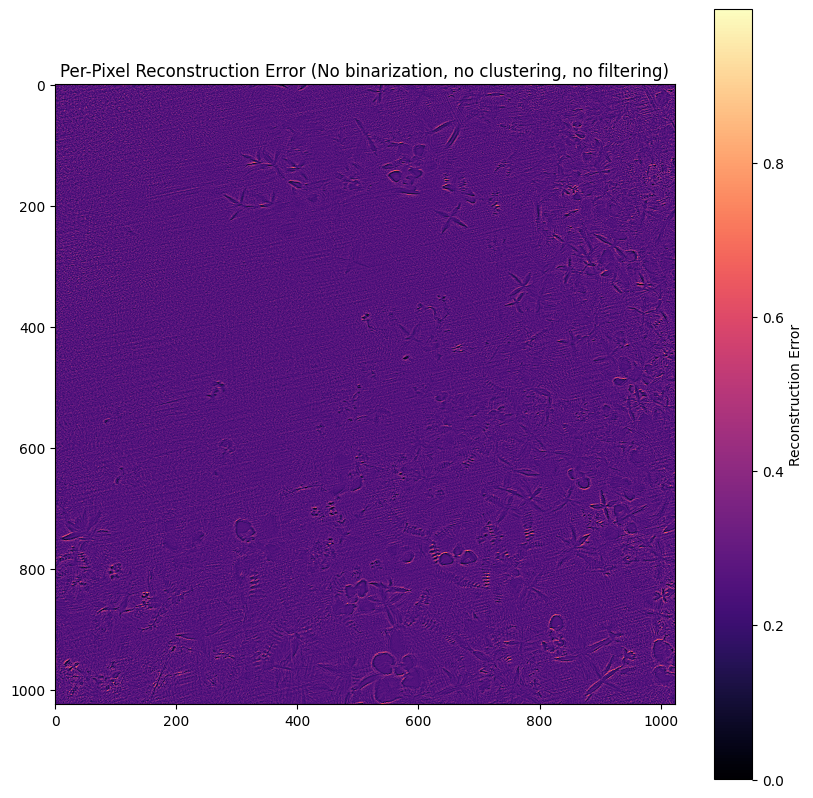

In [10]:
img_path = "proof/2.png"
img_input = Image.open(img_path).convert('L')
img_np = np.array(img_input, dtype=np.float32)/255.0
H, W = img_np.shape
to_tensor = transforms.ToTensor()

error_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

decoder.eval()
with torch.no_grad():
    for y in range(H - patch_size + 1):
        for x in range(W - patch_size + 1):
            patch = img_np[y:y+patch_size, x:x+patch_size]
            patch_tensor = to_tensor(patch).unsqueeze(0).to(device)
            z = encoder(patch_tensor) # (1,128)
            recon = decoder(z) # (1,1,64,64)
            recon_np = recon.squeeze(0).cpu().numpy()[0] # (64,64)
            mse = (patch - recon_np)**2
            error_map[y:y+patch_size, x:x+patch_size] += mse
            count_map[y:y+patch_size, x:x+patch_size] += 1.0

valid = (count_map > 0)
error_map[valid] /= count_map[valid]

plt.figure(figsize=(10,10))
plt.imshow(error_map, cmap='magma')
plt.colorbar(label='Reconstruction Error')
plt.title("Per-Pixel Reconstruction Error (No binarization, no clustering, no filtering)")
plt.show()